In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

## Part 1: Data Preparation and Exploration
1.	Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.
2.	Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.
3.	Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.


In [117]:
df = pd.read_csv('exchange_rate.csv')

In [36]:
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

In [37]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [86]:
df.set_index('Ex_rate',inplace=True)
df.index= pd.to_datetime(df.index)
df.dropna(inplace=True)
df.index

DatetimeIndex(['1970-01-01 00:00:00', '1970-01-01 00:00:00',
               '1970-01-01 00:00:00', '1970-01-01 00:00:00',
               '1970-01-01 00:00:00', '1970-01-01 00:00:00',
               '1970-01-01 00:00:00', '1970-01-01 00:00:00',
               '1970-01-01 00:00:00', '1970-01-01 00:00:00',
               ...
               '1970-01-01 00:00:00', '1970-01-01 00:00:00',
               '1970-01-01 00:00:00', '1970-01-01 00:00:00',
               '1970-01-01 00:00:00', '1970-01-01 00:00:00',
               '1970-01-01 00:00:00', '1970-01-01 00:00:00',
               '1970-01-01 00:00:00', '1970-01-01 00:00:00'],
              dtype='datetime64[ns]', name='Ex_rate', length=7588, freq=None)

In [125]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [124]:
model = ExponentialSmoothing(df['Ex_rate'],trend='add',seasonal='add',seasonal_periods=12).fit()

<Axes: >

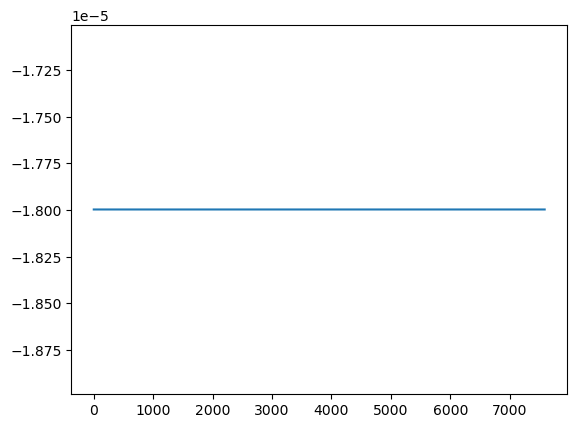

In [109]:
model.trend.plot()

<Axes: >

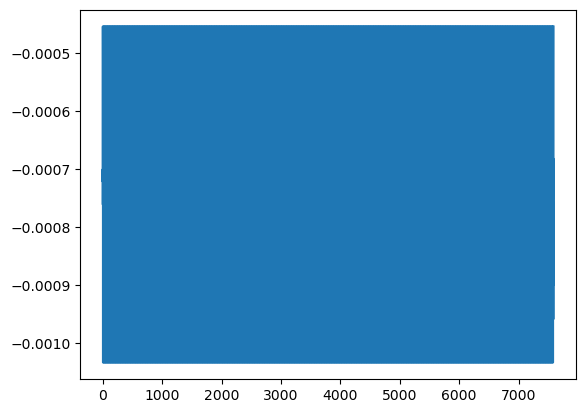

In [121]:
model.season.plot()

<Axes: >

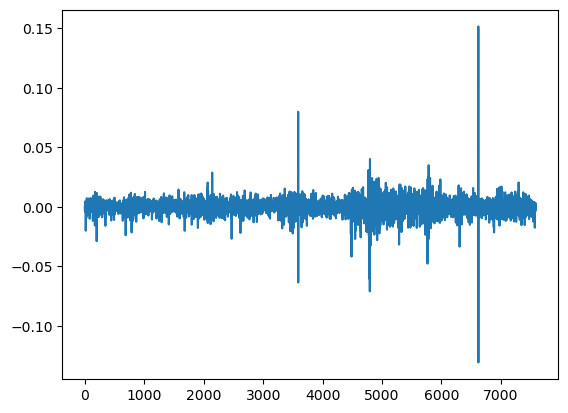

In [120]:
model.resid.plot()

## Part 2: Model Building - ARIMA
1.	Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series.
2.	Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.
3.	Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.
4.	Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.


In [128]:
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima_model import ARIMA

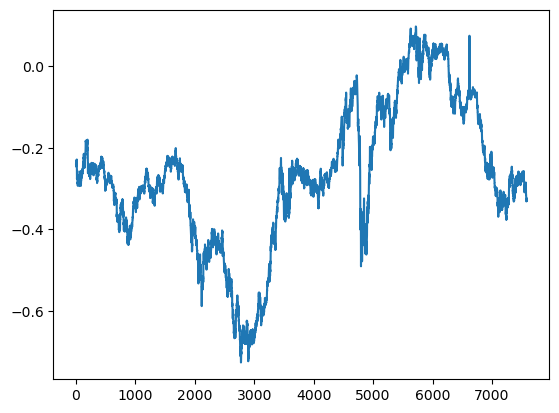

In [127]:
ts_data = df['Ex_rate']
ts_data_log = np.log(ts_data)
plt.plot(ts_data_log)

In [156]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    original = plt.plot(timeseries,color='blue',label='original')
    mean = plt.plot(timeseries,color='blue',label='Rolling mean')
    std = plt.plot(timeseries,color='blue',label='Rolling Std.Dev')
    plt.legend()
    df_test = adfuller(timeseries)
    my_output = pd.Series(df_test[0:4],index=['Test Statstics','p_value','#LagUsed','Num. Of Observtion Used'])
    for i,j in df_test[4].items():
        my_output['Critical Value (%s)'%i] =j
    print(my_output)

Test Statstics               -1.664994
p_value                       0.449233
#LagUsed                      1.000000
Num. Of Observtion Used    7586.000000
Critical Value (1%)          -3.431212
Critical Value (5%)          -2.861921
Critical Value (10%)         -2.566973
dtype: float64


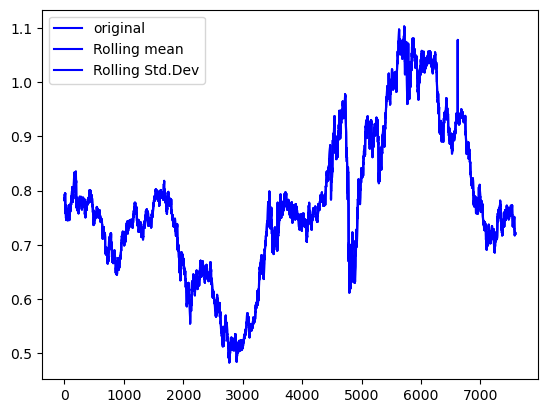

In [157]:
test_stationarity(df['Ex_rate'])

In [158]:
moving_avg = ts_data_log.rolling(window=12).mean()
moving_std = ts_data_log.rolling(window=12).std()

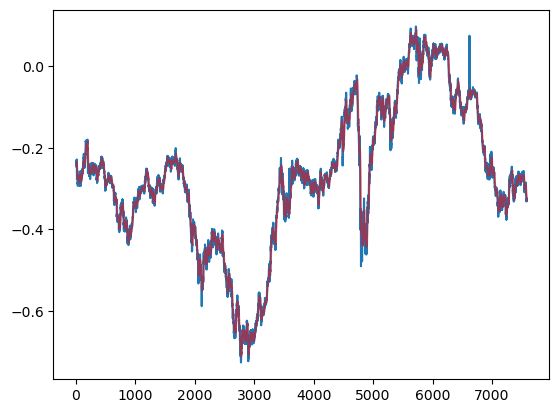

In [159]:
plt.plot(ts_data_log)
plt.plot(moving_avg,color='red',alpha=0.5)

In [160]:
ts_data_log_diff = ts_data_log - moving_avg
ts_data_log_diff.dropna(inplace=True)

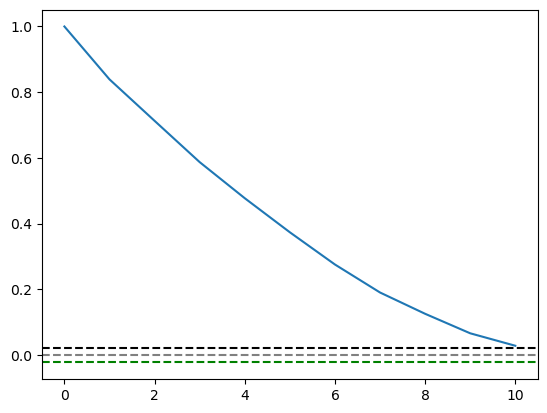

In [161]:
plt.plot(np.arange(0,11),acf(ts_data_log_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='grey')
plt.axhline(y=-1.96/np.sqrt(len(ts_data_log_diff)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(ts_data_log_diff)),linestyle='--',color='black')

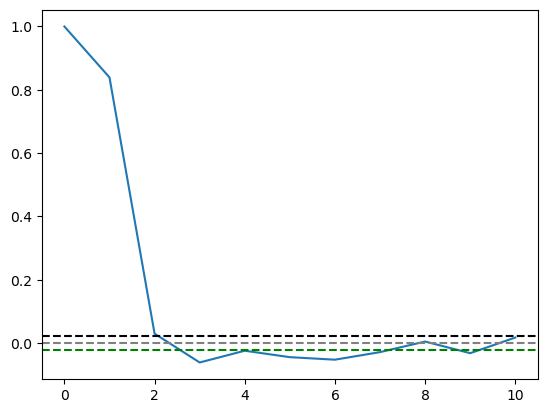

In [162]:
plt.plot(np.arange(0,11),pacf(ts_data_log_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='grey')
plt.axhline(y=-1.96/np.sqrt(len(ts_data_log_diff)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(ts_data_log_diff)),linestyle='--',color='black')

In [167]:
import statsmodels.api as sms
from statsmodels.tsa.arima.model import ARIMA

In [168]:
model = ARIMA(df['Ex_rate'],order=(1,1,1))

In [169]:
res = model.fit()

In [170]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Thu, 16 May 2024   AIC                         -56102.322
Time:                        17:56:27   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.000    3.58e-05    3.62e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2865078.33
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        98.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: >

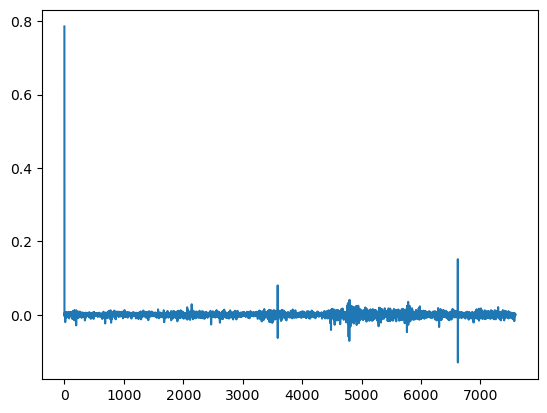

In [181]:
res.resid.plot()

In [171]:
df['forecast'] = res.predict(start=10,end=190,dynamic=True)

In [173]:
res.predict()

0       0.000000
1       0.785500
2       0.782286
3       0.786058
4       0.786089
          ...   
7583    0.718837
7584    0.718522
7585    0.721400
7586    0.723017
7587    0.721136
Name: predicted_mean, Length: 7588, dtype: float64

In [174]:
res.forecast(steps=20)
res.fittedvalues

0       0.000000
1       0.785500
2       0.782286
3       0.786058
4       0.786089
          ...   
7583    0.718837
7584    0.718522
7585    0.721400
7586    0.723017
7587    0.721136
Length: 7588, dtype: float64

## Part 3: Model Building - Exponential Smoothing
1.	Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model (Simple, Holt’s Linear, or Holt-Winters).
2.	Parameter Optimization: Use techniques such as grid search or AIC to find the optimal parameters for the smoothing levels and components.
3.	Model Fitting and Forecasting: Fit the chosen Exponential Smoothing model and forecast future values. Compare these forecasts visually with the actual data


In [175]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [177]:
hw_model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal='add', seasonal_periods=12).fit()
hw_forecast = hw_model.forecast(steps=12)

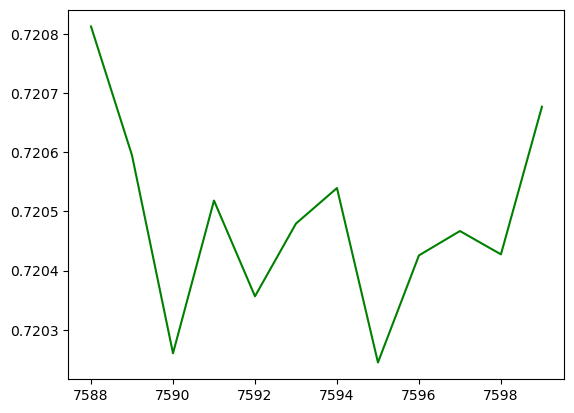

In [190]:
plt.plot(hw_forecast, color='green')
plt.show()

In [194]:
from sklearn.model_selection import TimeSeriesSplit

In [207]:
trend_options = ['add', 'mul', None]
seasonal_options = ['add', 'mul', None]
seasonal_periods_options = [6, 12, 24]
best_score = float('inf')
best_params = {}

In [208]:
tscv = TimeSeriesSplit(n_splits=5)

In [209]:
for trend in trend_options:
    for seasonal in seasonal_options:
        for seasonal_periods in seasonal_periods_options:
            current_score = 0
            n_folds = 0
            for train_index, test_index in tscv.split(df):
                train, test = df.iloc[train_index], df.iloc[test_index]
                try:
                    model = ExponentialSmoothing(train['Ex_rate'], trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit()
                    forecast = model.forecast(steps=len(test))
                    score = ((forecast - test['Ex_rate']) ** 2).mean()
                    current_score += score
                    n_folds += 1
                except Exception as e:
                    print(f"Error with params trend={trend}, seasonal={seasonal}, seasonal_periods={seasonal_periods}: {e}")
            if n_folds > 0:
                current_score /= n_folds
            if current_score < best_score:
                best_score = current_score
                best_params = {'trend': trend, 'seasonal': seasonal, 'seasonal_periods': seasonal_periods}

In [210]:
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Best parameters: {'trend': 'mul', 'seasonal': 'mul', 'seasonal_periods': 12}
Best score: 0.0108745392556045


In [212]:
hw_model1 = ExponentialSmoothing(df['Ex_rate'], trend='mul', seasonal='mul', seasonal_periods=12).fit()
hw_forecast1 = hw_model1.forecast(steps=12)

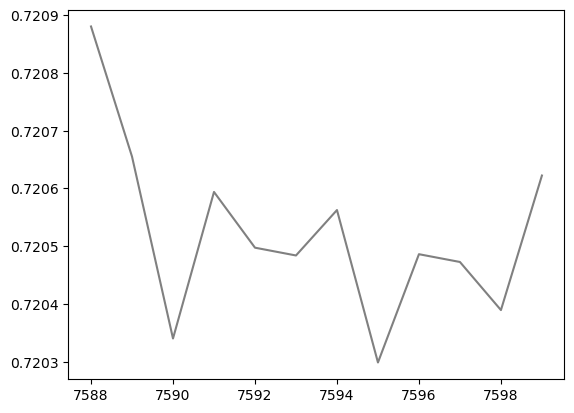

In [213]:
plt.plot(hw_forecast1, color='grey')
plt.show()

## Part 4: Evaluation and Comparison
1.	Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.
2.	Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.
3.	Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.


In [214]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [222]:
forecast_steps = 12

In [225]:
hw_mae = mean_absolute_error(df['Ex_rate'][-forecast_steps:], hw_forecast)
hw_rmse = mean_squared_error(df['Ex_rate'][-forecast_steps:], hw_forecast, squared=False)
print("Mean Absloute Error:", hw_mae)
print('Root Mean Squared Error:', hw_rmse)

Mean Absloute Error: 0.0016033387135636252
Root Mean Squared Error: 0.0018760428593741743
